In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 18 21:47:28 2021

@author: mreza2
"""

import pandas as pd
import os
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
#from keras.layers.normalization import BatchNormalization

data_df = pd.read_csv('/content/drive/MyDrive/ECE 542 Neural Network/ProjC/raw_train_data_all_Subjects.csv')
len(data_df)

X_df = data_df.drop(['time', 'target'], axis=1)
y_df = data_df.target
n_train = round(0.7*len(data_df)/4)*4
n_test = len(data_df) - n_train

Xs = X_df.to_numpy()
ys = y_df.to_numpy()
# X_train = Xs[:n_train, :]
# y_train = ys[:n_train]
# X_test = Xs[n_train:, :]
# y_test = ys[n_train:]
# print(X_train.shape)
# print(X_test.shape)

# split a multivariate sequence into samples
def split_sequences(features,label, n_steps):
    X, y = list(), list()
    for i in range(len(features)):
        #if i % 4 == 0:
            end_ix = i + n_steps
            if end_ix > len(features):
                break
            seq_x, seq_y = features[i:end_ix], label[end_ix-1]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

n_steps=48
X, y = split_sequences(Xs, ys, n_steps)

train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.3, stratify=y)
#train_images, train_labels = X, y


In [ ]:
l_0 = (train_labels==0)
l_1 = (train_labels==1)
l_2 = (train_labels==2)
l_3 = (train_labels==3)
print(sum(l_0), sum(l_1), sum(l_2), sum(l_3))

552266 34196 41975 105532


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = {l:c for l,c in zip(np.unique(train_labels), class_weights)}
print(class_weights)

{0: 0.3322533887655586, 1: 5.365898058252427, 2: 4.371465157832043, 3: 1.7387356441648032}


In [ ]:
from keras.callbacks import ModelCheckpoint

n_features = train_images.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=40, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
#model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])




#create callback
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                            monitor='val_loss',
                            verbose=1, 
                            save_best_only=True,
                            mode='min')
callbacks = [checkpoint]

#fit the model
history = model.fit(train_images, train_labels,
                  batch_size=500,
                  epochs=30,
                  validation_data=(test_images, test_labels),
                  callbacks=callbacks, class_weight=class_weights)




Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1468/1468 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.8329
Epoch 00001: val_loss improved from inf to 0.39668, saving model to my_best_model.hdf5
1468/1468 [==============================] - 47s 12ms/step - loss: 0.3474 - accuracy: 0.8329 - val_loss: 0.3967 - val_accuracy: 0.8701
Epoch 2/30
1466/1468 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.8894
Epoch 00002: val_loss improved from 0.39668 to 0.30309, saving model to my_best_model.hdf5
1468/1468 [==============================] - 16s 11ms/step - loss: 0.2076 - accuracy: 0.8894 - val_loss: 0.3031 - val_accuracy: 0.8978
Epoch 3/30
1465/1468 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9051
Epoch 00003: val_loss improved from 0.30309 to 0.27402, saving model to my_best_model.hdf5
1468/1468 [==============================] - 16s 11ms/step - loss: 0.1697 - accuracy: 0.9051 - val_loss: 0.2740 - val_accuracy: 0.9073
Epoch 4/30
1464/1468 [=====================

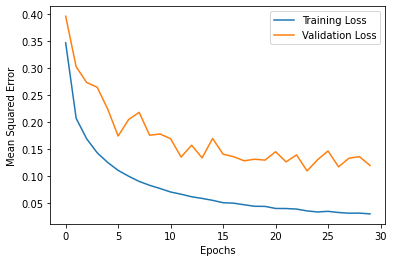

9830/9830 [==============================] - 22s 2ms/step
f1 score:  [0.9792684  0.96919032 0.95371043 0.92098116]
confusion matric: 
 [[230415    616   1442   4213]
 [   269  14376      4      7]
 [   239      3  17729     18]
 [  2977     15     15  42221]]


In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()


#Load and evaluate the best model version
model_best = load_model(filepath)
yhat = model_best.predict(test_images, verbose=1)
yhat = (np.argmax(yhat, axis=1))
cm = (confusion_matrix(test_labels, yhat))
f1 = (f1_score(test_labels, yhat, average=None))
print('f1 score: ', f1)
print('confusion matric: \n', cm)

In [1]:
a=230415+616+1442+4213+269+14376+4+7+239+3+17729+18+2977+15+15+42221
b=230415+14376+17729+42221
b/a

0.9687880493007671

In [ ]:
model.save("ProjC_model")

In [ ]:
def test_data_pre(features, n_steps=48):
    X = list()
    features = np.vstack((features[0:47],features))
    for i in range(len(features)):
        if i % 4 == 0:
            end_ix = i + n_steps
            if end_ix > len(features):
                break
            seq_x = features[i:end_ix]
            X.append(seq_x)
    return np.array(X)


In [ ]:
sub_id = ['09', '10', '11', '12']
for i in sub_id:
  x_df = pd.read_csv(f'/content/drive/MyDrive/ECE 542 Neural Network/ECE542_fa2021_Project_TerrainRecognition/TestData/subject_0{i}_01__x.csv')
  x = x_df.to_numpy()
  x_test = test_data_pre(x, 48)
  ypred = model_best.predict(x_test, verbose=1)
  ypred = (np.argmax(ypred, axis=1))
  ypred = np.int8(ypred)
  # np.savetxt(f"/content/drive/MyDrive/ECE 542 Neural Network/ProjC/Test_data_pred_usingBestModel/subject_0{i}_01__y.csv", ypred, delimiter=",")
  pd.DataFrame({'y':ypred}).to_csv(f"/content/drive/MyDrive/ECE 542 Neural Network/ProjC/Test_data_pred_usingBestModel/subject_0{i}_01__y.csv", index = False, header = None)

355/355 [==============================] - 1s 2ms/step


In [ ]:
type(ypred)

numpy.ndarray

In [ ]:
x10_df = pd.read_csv('/content/drive/MyDrive/ECE 542 Neural Network/ECE542_fa2021_Project_TerrainRecognition/TestData/subject_010_01__x.csv')
x10 = x10_df.to_numpy()
x10_test = test_data_pre(x10, 48)
print(x10.shape)
print(x10_test.shape)

(49080, 6)
(12270, 48, 6)


In [ ]:
x11_df = pd.read_csv('/content/drive/MyDrive/ECE 542 Neural Network/ECE542_fa2021_Project_TerrainRecognition/TestData/subject_011_01__x.csv')
x11 = x11_df.to_numpy()
x11_test = test_data_pre(x11, 48)
print(x11.shape)
print(x11_test.shape)

(51760, 6)
(12940, 48, 6)


In [ ]:
x12_df = pd.read_csv('/content/drive/MyDrive/ECE 542 Neural Network/ECE542_fa2021_Project_TerrainRecognition/TestData/subject_012_01__x.csv')
x12 = x12_df.to_numpy()
x12_test = test_data_pre(x12, 48)
print(x12.shape)
print(x12_test.shape)

(45318, 6)
(11330, 48, 6)


In [ ]:
x = (np.arange(54)).reshape(9,6)
x

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41],
       [42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53]])

In [ ]:

np.savetxt("/content/drive/MyDrive/ECE 542 Neural Network/ProjC/Test_data_pred/test.csv", x, delimiter=",")

In [ ]:
print(len(y))

12
